<h1 align="center">Securing Sensitive Data: AI Methods for Detecting Personally Identifiable Information</h1>

<h5 align="center">Advanced Business Analytics (42578) - Exam Project</h5>


<h5 align="center">Group Name: Mind Machines</h5>
<h5 align="center">Students: Christoffer Wejendorp (s204090), Jasmin Thari (s204155), and Marah Marak (s182946)</h5>




### Structure of this notebook

This notebook is organized into seven distinct sections, each aimed at guiding you through various stages of the project from initial setup to in-depth analysis and discussions:

1. **[Introduction](#1)**: Provides an overview of the objectives and scope of the project.

2. **[Get Started](#2)**: Outlines the setup procedures including the installation of required packages within the notebook.

3. **[Data & Pre-processing](#3)**: Details the dataset used in this project, followed by comprehensive steps involved in the data cleaning process to prepare the data for analysis.

4. **[Exploratory Data Analysis](#4)**: Dives into the dataset through various visualization techniques to uncover patterns, trends, and insights which inform further analyses.

5. **[Named Entity Recognition using Regex](#5)**: Introduces a baseline model for Named Entity Recognition (NER) utilizing regular expressions (Regex). This section demonstrates how to apply Regex patterns and rules to identify named entities within the text.

6. **[Named Entity Recognition Using Transformer Model](#6)**: Advances the NER approach by implementing the DistilBert Transformer model to achieve a more sophisticated and effective entity recognition.

7. **[Discussion](#7)**: Concludes with a critical analysis of the results obtained, discussing both the strengths and limitations of the methods used and suggesting potential areas for future work.

### Table of Contents
1. **[Introduction](#1)**
2. **[Get Started](#2)**
3. **[Data & Pre-processing](#3)**
4. **[Exploratory Data Analysis](#4)**
5. **[Named Entity Recognition using Regex](#5)**
6. **[Named Entity Recognition Using Transformer Model](#6)**
7. **[Discussion](#7)**

__________

<a id="1"></a>
## Section 1: Introduction

In the age of rapid advancements in artificial intelligence and generative AI technologies, the ability to responsibly manage sensitive information is more crucial than ever. This project, *Securing Sensitive Data: AI Methods for Detecting Personally Identifiable Information*, aims to address the growing concern surrounding the protection of personal data, especially in contexts where large language models (LLMs) are employed. A primary example is the use of student essays by universities wishing to train AI models. These essays often contain personally identifiable information (PII) that must be carefully identified and redacted to maintain confidentiality and comply with data protection laws.

The motivation behind this project is driven by the need to balance the utilization of generative AI in educational settings with stringent data security measures. As universities and other institutions increasingly rely on AI to enhance learning and research, ensuring the privacy of individuals represented in training datasets becomes essential. To handle this challenge, we will deploy Named Entity Recognition (NER) techniques to effectively identify and remove PII from texts.

Our approach begins with the application of regular expressions (Regex), a basic yet powerful tool for pattern recognition in texts. This will serve as our baseline model for detecting straightforward instances of PII. Subsequently, we will enhance the model by incorporating a more sophisticated method using the DistilBert Transformer model. Through these methods, we aim to create a safer data environment that respects individual privacy while enabling the progressive use of AI in education.

The methodologies and models developed here are not only applicable to academic settings but can also be extended to corporate environments where data privacy is paramount. As companies increasingly integrate AI technologies such as chatbots to interact with customers, the need to comply with strict regulations like the General Data Protection Regulation (GDPR) becomes critical.

__________

<a id="2"></a>
## Section 2: Get Started

In [1]:
# Standard libraries
import json
import itertools
import re
import string
from collections import Counter
from itertools import chain
import math

# Data manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import ast

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import HTML

# NLP
import spacy
from spacy import displacy
from spacy.tokens import Doc, Span
from spacy.lang.en import English
spacy_nlp = spacy.load('en_core_web_sm')
eng_tokenizer = English().tokenizer

# Text Processing and Analysis
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, ImageColorGenerator
import random
from nltk.corpus import PlaintextCorpusReader
import nltk
import string
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score

# Import custom functions
from Functions.Spacy_Tokenizer import adjust_token_labels, refine_punctuation_labels, create_bio_labels
from Functions.Ner_Visualizer import *
from Functions.tfidf_wordclouds import *

# Ignore warnings
pd.options.mode.chained_assignment = None

In [2]:
import plotly.graph_objects as go

# Define the custom color theme
color_theme = {
    'three_colors': ['#57634B', '#D4793A', '#527184'],  
    'four_colors': ['#85977D', '#8498A5', '#587F86', '#BD8A3D'],  
    'five_colors': ['#57634B', '#D4793A', '#527184', '#CFA802', '#BBB599'], 
    'twelve_colors': ['#57634B', '#85977D', '#8498A5', '#527184', '#E9B649', '#BD8A3D', '#D4793A', 
                      '#7D1F1D', '#BB6D71', '#BBB599', '#BE477D', '#CDADE6']}

__________

<a id="1"></a>
# Section 3: Data

This project uses data from a Kaggle competition titled *The Learning Agency Lab - PII Data Detection*. The primary dataset includes approximately 6,807 essays contributed by students from an online course, each essay responding to a single assignment that tasked students with applying course material to a real-world problem. The objective is to annotate personally identifiable information (PII) within each essay. To preserve privacy, all reak PII has been replaced with surrogate identifiers using a semi-automated process. You can access this dataset [here](https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data).

Given that the initial dataset predominantly included the *B-NAME_STUDENT* class and lacks diversity in PII types, additional data was necessary. This supplementary dataset is generated by a Large Language Model (LLM) and us also available on Kaggle. The dataset consists of 4,434 texts complete with annotations similar to the original training data. These texts, generated across eight different prompts, vary from life summaries to narratives. You can find this dataset [here](https://www.kaggle.com/datasets/alejopaullier/pii-external-dataset). Both datasets will be utilized for this project.

### Project Goals
The aim of this project is to identify and annotate various types of PII, which include:

- **Student Names:** Identifying names specific to students, excluding names of instructors, authors, or other individuals.
- **Student Emails:** Detecting email addresses belonging to students.
- **Student Username:** Recognizing usernames associated with students.
- **Student ID Number:** Identifying students' ID numbers or social security numbers.
- **Student Phone Number:** Detecting phone numbers linked to students.
- **Personal URL:** Recognizing URLs that could potentially identify students.
- **Student Address:** Identifying street addresses related to students.

### Data Structure
The data provided includes detailed information about each essay:

- **index (int):** An index number assigned to each essay.
- **document id (int):** A unique integer identifier for each essay.
- **full_text (string):** The complete text of each essay in UTF-8 format.
- **tokens (list):** A sequence of tokens, derived using the SpaCy English tokenizer.
- **trailing_whitespace (list):** A list indicating whether a space follows each token.
- **labels (list):** These labels classify each token according to the type of PII they represent, using the BIO (Beginning, Inner, Outer) format:
  - **B-** prefix denotes the start of a PII entity.
  - **I-** indicates continuation of a PII entity.
  - **O** represents tokens unrelated to PII.

## 3.1 Data Loading

### 3.1.1 Loading the first data set

In [3]:
# Load data in dictionary and dataframe format
with open('data/train.json', 'r') as f:
    data = json.load(f)

data_df = pd.read_json('data/train.json')

print('Number of documents:',len(data_df))

Number of documents: 6807


In [4]:
data_df.head(2)

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."


### 3.1.2 Load LLM generated data

In [5]:
# Load LLM generated data in dataframe format
llm_data_df = pd.read_csv('data/pii_dataset.csv')
print('Number of documents:',len(llm_data_df))

Number of documents: 4434


In [6]:
llm_data_df.head(2)

,document,text,tokens,trailing_whitespace,labels,prompt,prompt_id,name,email,phone,job,address,username,url,hobby,len
0,1073d46f-2241-459b-ab01-851be8d26436,"My name is Aaliyah Popova, and I am a jeweler ...","['My', 'name', 'is', 'Aaliyah', 'Popova,', 'an...","[True, True, True, True, True, True, True, Tru...","['O', 'O', 'O', 'B-NAME_STUDENT', 'I-NAME_STUD...",\n Aaliyah Popova is a jeweler with 13 year...,1,Aaliyah Popova,aaliyah.popova4783@aol.edu,(95) 94215-7906,jeweler,97 Lincoln Street,NaN,NaN,Podcasting,363
1,5ec717a9-17ee-48cd-9d76-30ae256c9354,"My name is Konstantin Becker, and I'm a develo...","['My', 'name', 'is', 'Konstantin', 'Becker,', ...","[True, True, True, True, True, True, True, Tru...","['O', 'O', 'O', 'B-NAME_STUDENT', 'I-NAME_STUD...",\n Konstantin Becker is a developer with 2 ...,1,Konstantin Becker,konstantin.becker@gmail.com,0475 4429797,developer,826 Webster Street,NaN,NaN,Quilting,255



> - Let's explore the number of different prompt IDs present in the data.


In [7]:
len(llm_data_df['prompt_id'].unique())

8

> - Below, we display a random sample for each prompt ID, where the prompt ID represents a category, each prompt within the same category is unique.

In [8]:
# Group by 'prompt_id', sample one record from each group, and reset index to flatten the DataFrame
sampled_prompts = llm_data_df.groupby('prompt_id').apply(lambda x: x.sample(1), include_groups=False).reset_index(drop=False)
html = '<table>'
html += '<tr><th>Prompt ID</th><th>Text</th></tr>'  
for index, row in sampled_prompts.iterrows():
    html += f'<tr><td>{row["prompt_id"]}</td><td>{row["prompt"]}</td></tr>'

html += '</table>'
display(HTML(html))

Prompt ID,Text
0,"Write a fictional semi-formal biography in first person for Ashok Wagner. Add the following information about him/her randomly inside the text: name is Ashok Wagner, phone number is +86 19820 6254, email is ashok_wagner@yahoo.org, address is 6412 Lenawee Street."
1,"Natalia Petrov is a waiter with 2 years of experience. Write a detailed example in first person of a job-related project he/her did in the past. Add the following information about him/her randomly inside the text: name is Natalia Petrov, phone number is 0334 5934219, email is natalia.petrov@outlook.edu, hobby is Crossword puzzles, address is 2812 Jasper Street Southeast."
2,"Taio Roy is a nutritionist. Write about a job-related project he/her did in the past including some of the following information: phone number is +86 14803 2218, email is taio.roy@aol.gov, webpage is http://www.troy.edu/search"
3,"Galina Mitsubishi is a army lieutenant. Write a first person summary of something he solved in his job. Add the following information about him/her (randomly please) inside the text: name is Galina Mitsubishi, email is galinamitsubishi@gmail.net, address is 12725 Landmark Street."
4,"Write a fictional semi-formal biography in first person for Adrian Dong. Add the following information about him/her randomly inside the text: name is Adrian Dong, profile at Instagram is adong, email is adrian_dong@hotmail.gov, webpage is www.adriandong.com/search.asp. It is important to include this information in different parts of the text."
5,"Gaspard Schafer is a orthopediatrician with 18 years of experience. Write a detailed example in first person of a job-related project he/her did in the past. Add the following information about him/her randomly inside the text: name is Gaspard Schafer, webpage is http://www.gschafer.edu.css, profile at Twitter is gaspard_schafer82, address is 93110 Cynthia Walk Apt. 308."
6,"Pedro Butcher is a opthalmologist. Write about a job-related project he/her did in the past including some of the following information: phone number is 075-4343-6743, profile at LinkedIn is pedro_butcher29. It is important to include this information randomly throughout the text."
7,"Yuze Ito is a doctor. Write a first person summary of something he solved in his job. Add the following information about him/her (randomly please) inside the text: name is Yuze Ito, email is yuzeito9164@yahoo.net, address is 67269 Carmen Pass, profile at X.com is yuzeito, webpage is http://www.yuze_ito.org."


> - From the output, we can observe that the majority of the prompts are either related to historical writing or summaries of job-related topics.

## 3.2 Pre-processing

> - First, we will preprocess both datasets to ensure they are aligned. For example, we will rename the text columns in both datasets to "text", add a new column to track which data is generated by LLMs, and assign a prompt ID of -1 to the non-generated data to facilitate tracking.

In [9]:
data_df = data_df.rename(columns={'full_text':'text'}) # Rename column to 'text'
data_df['llm_generated'] = False # Add column to indicate if the text was generated by LLM
data_df['prompt_id'] = -1  # Add column to indicate the prompt id

In [10]:
llm_data_df['llm_generated'] = True # Add column to indicate if the text was generated by LLM

llm_data_df[["tokens", "trailing_whitespace", "labels"]] = llm_data_df[["tokens", "trailing_whitespace", "labels"]].map(ast.literal_eval) # Convert string to list
llm_data_df["document"] = llm_data_df["document"].astype("category").cat.codes + (data_df.document.max() + 1) # make sure document id is unique and changing to int

**Addressing the Punctuation Issue in the LLM generated data set**:

> In the context of text processing, particularly when handling datasets for named entity recognition (NER), punctuation plays a crucial role in determining the boundaries and labels of tokens. The standard tokenization by tools like SpaCy segment a phrase such as "Charles, by" into ["Charles", ",", "by"] with trailing spaces marked as [False, True, True], and labels ["B-NAME-STUDENT", "O", "O"]. This segmentation accurately reflects the presence of punctuation as separate from named entities, even when there's no space between them.
>
> However, the LLM generated dataset presents a unique challenge, where all token are seperated by space so its tokenization will be ["Charles,", "by"] [True, True] ["B-NAME-STUDENT", "O"] and thus tokens without space are considered single token and are given single labels. While the tokenization will leas to the same text e.g ["Char", "les", ",", "_by"], the model labels will be different ["B-NAME-STUDENT", "B-NAME-STUDENT", "B-NAME-STUDENT", "O"] instead of appropriate ["B-NAME-STUDENT", "B-NAME-STUDENT", "O", "O"]. 
>
>So, this approach results in punctuation being considered part of a preceding token, thus receiving a single, unified label. Consequently, when aligning the LLM dataset's tokenization with the original, we encounter difference.
>
>To resolve this, adjustments are necessary to ensure that the dataset aligns more closely with standard tokenization and labeling practices. This involves re-evaluating tokens and labels to correctly identify and separate punctuation from named entities, thereby avoiding the mislabeling that can confuse NER models. By addressing this issue, we aim to improve the dataset's utility for training more accurate and reliable NER systems.

> NB! The following code uses functions from `Spacy_Tokenizer.py` file. 

In [11]:
llm_data_df_tokenized = llm_data_df.apply(adjust_token_labels, axis=1)
llm_data_df_tokenized["labels"] = llm_data_df_tokenized.apply(refine_punctuation_labels, axis=1).apply(create_bio_labels)
llm_data_df_tokenized['text'] = llm_data_df['tokens'].apply(lambda x: ' '.join(x))
llm_data_df_tokenized[['prompt_id', 'llm_generated']] = llm_data_df[['prompt_id', 'llm_generated']]

In [12]:
llm_data_df_tokenized.head(2)

,document,tokens,trailing_whitespace,labels,text,prompt_id,llm_generated
0,22968,"[My, name, is, Aaliyah, Popova, ,, and, I, am,...","[True, True, True, True, False, True, True, Tr...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O...","My name is Aaliyah Popova, and I am a jeweler ...",1,True
1,24398,"[My, name, is, Konstantin, Becker, ,, and, I, ...","[True, True, True, True, False, True, True, Fa...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O...","My name is Konstantin Becker, and I'm a develo...",1,True


In [13]:
print("Thus, the first row's tokens are transformed from " + str(len(llm_data_df_tokenized['tokens'].iloc[0])) + " to " + str(len(llm_data_df['tokens'].iloc[0])) + " tokens and are more aligned with the first data set and the more approciate tokenizer.")

Thus, the first row's tokens are transformed from 411 to 363 tokens and are more aligned with the first data set and the more approciate tokenizer.


### 3.2.1 Combine data sets

> - Both that data sets have now been pre-processed and we are ready to combine them into one data set.

In [14]:
df = pd.concat([data_df, llm_data_df_tokenized], ignore_index=True)

In [53]:
print('Number of documents:',len(df))

Number of documents: 11241


In [54]:
df.head(2)

,document,text,tokens,trailing_whitespace,labels,llm_generated,prompt_id
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-...",False,-1
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O...",False,-1


### 3.2.2 Encode target

> The last step, will be to encode the targets as one hot encoding. 
>
> !NB The function used from `Spacy_Tokenizer.py` file. 

In [15]:
def encode_labels(df):
    df = df.copy()
    df["unique_labels"] = df["labels"].apply(lambda x: set(
        [l.split('-')[1] if l != 'O' else l for l in x]
         ))

    mlb = MultiLabelBinarizer()
    one_hot_encoded = mlb.fit_transform(df['unique_labels'])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)
    df = pd.concat([df, one_hot_df], axis=1)
    
    # add 'OTHER' column which is only true when we have no other label in text
    df['OTHER'] = df['unique_labels'].apply(lambda x: 1 if len(x - {"O"}) == 0 else 0)
    
    return df, list(mlb.classes_) + ['OTHER']

In [ ]:
# skriv mere forklaringen her

In [16]:
df, label_classes = encode_labels(df)

In [19]:
df.head(2)

,document,text,tokens,trailing_whitespace,labels,llm_generated,prompt_id,unique_labels,EMAIL,ID_NUM,NAME_STUDENT,O,PHONE_NUM,STREET_ADDRESS,URL_PERSONAL,USERNAME,OTHER
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-...",False,-1,"{NAME_STUDENT, O}",0,0,1,1,0,0,0,0,0
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O...",False,-1,"{NAME_STUDENT, O}",0,0,1,1,0,0,0,0,0


__________

<a id="4"></a>
# Section 4: Exploratory Data Analysis

## 4.1 Data Visualization

### 4.1.1 Target Distrbution

> - First, we are examining the frequency of each target in all the documents excluding target "O".

In [ ]:
labels = df['labels'].tolist()
# Flatten the list of lists
flattened_labels = list(itertools.chain.from_iterable(labels))
# Count the occurrences of each label
label_counts = Counter(flattened_labels)
# Separate the labels and their counts for plotting
labels, counts = zip(*label_counts.items())

# add the number on top of each bar 
labels = list(labels)
counts = list(counts)
for i in range(len(labels)):
    labels[i] = labels[i] + ' (' + str(counts[i]) + ')'
    
# Create the bar plot 
fig = go.Figure([go.Bar(x=labels[1:], y=counts[1:], marker_color=color_theme['three_colors'][2])])
fig.update_layout(title_text='Frequency of each label', xaxis_title='Labels', yaxis_title='Frequency')
fig.show()

> - It is evident that the most common targets within our data are *B-NAME-STUDENT*, *I-NAME-STUDENT*, *B-STREET_ADDRESS*, and *I-STREET_ADDRESS*. Notably, *NAME-STUDENT* appears most frequently.
> - We also find that certain targets are notably rare, such as *B-ID_NUM*, *I-URL_PERSONAL*, and *I-ID_NUM*.
> - Additionally, we observe the absence of potential targets like *I-EMAIL* and *I-USERNAME*. However, the scarcity of these targets is expected since emails and usernames typically do not extend beyond a single word.
> - Overall, we have a diverse array of targets, which is crucial for effective model training.

> In the following analysis, we will examine the distribution of unique variables across each document.

SKRIV MERE FORKLARENDE TEKST

In [ ]:
df['unique_labels'] = df['labels'].apply(lambda x: list(set(x)))
df['num_unique_labels'] = df['unique_labels'].apply(len)

# Histogram of number of unique labels per document
fig = px.histogram(df, x='num_unique_labels', nbins=20,
                   labels={'num_unique_labels': 'Number of unique labels'},
                   title='Histogram of number of unique labels per document',
                   color_discrete_sequence=[color_theme['three_colors'][2]])
fig.update_layout(yaxis_title='Frequency') 
fig.show()


TILFØJ PLOT DER HVOR MANGE DOKUMENT VI HAR UDEN NOGEN LABELS

> - It is commonly observed that each document typically contains at least one unique target.
> - Additionally, it is noteworthy that some texts contain as many as 6 to 8 unique labels.

> - It is interesting to examine the number of targets in each document when excluding the "O" label.

In [ ]:
df['num_labels'] = df['labels'].apply(lambda labels: len([label for label in labels if label != "O"]))
filtered_df = df[df['num_labels'] > 0]
# Histogram of number of unique labels per document
fig = px.histogram(filtered_df, x='num_labels', nbins=50, 
                   labels={'num_labels': 'Number of labels'},
                   title='Histogram of number of labels per document', color_discrete_sequence=[color_theme['three_colors'][2]])
fig.update_layout(yaxis_title='Frequency') 
fig.show()

In [23]:
print("Number of documents without any target:", len(df['num_labels']==0))

Number of documents without any target: 11241


> - We observe that there are 11,241 documents that contain no targets.
> - Additionally, a small number of documents feature a high count of targets.
> - For the majority, however, documents typically have between 5 to 15 targets.

### 4.1.2 Document distribution

> It is interesting to investigate the distribution of documents in terms of text length and token count. 

> - First, we will visualize the lengths of text for documents, comparing those with labels to those without.

# rename number of characters in each document 

In [ ]:
df_with_labels = df[df['labels'].apply(lambda x: len(set(x)) > 1)] #with labels
df_non_labels = df[df['labels'].apply(lambda x: 'O' in x and len(set(x)) == 1)] #without labels 

df_with_labels['Documents'] = 'With Labels'
df_non_labels['Documents'] = 'Without Labels'

# Calculate text length
df['len_text'] = df['text'].apply(len)
df_with_labels['len_text'] = df_with_labels['text'].apply(len)
df_non_labels['len_text'] = df_non_labels['text'].apply(len)

# Combine the dataframes
combined_df = pd.concat([df_with_labels, df_non_labels])

# Plotting
# use the custom colors in the plot
fig = px.histogram(combined_df, x='len_text', color='Documents', color_discrete_sequence=color_theme['three_colors'][1:3], labels={'len_text': 'Length of text'},
                   nbins=500, title='Histogram of Length of Text per Document') 
fig.update_layout(yaxis_title='Frequency', xaxis_title='Length of text')
# Show the plot
fig.show()

> - The distribution of text length for both documents with and without labels approximates a heavy-tailed normal distribution. However, it is evident that there are more longer texts among the documents without any labels.

> - Now we will investigate the tokens

In [ ]:
combined_df['Length of tokens'] = combined_df['tokens'].apply(len)
# Plotting
fig = px.histogram(combined_df, x='Length of tokens', color='Documents', color_discrete_sequence=color_theme['three_colors'][1:3],
                   nbins=500, title='Histogram of Length of Tokens per Document')
fig.show()

> - The distributions are quite similar to those previously observed, which is not surprising given that text length and token distribution typically correlate closely.

## 4.2 NER using spaCy 

> - Next, we will use the spaCy library to visualize text data along with their corresponding labels for NER.

> !NB We are using function from `Ner_Visualizer.py` file. 

> - First, we are presenting a text that contains the highest number of unique labels, which, in our dataset, reached a maximum of eight.

In [26]:
visualize_ner(df.sort_values(by=["num_unique_labels"], ascending=False).reset_index(drop=True).iloc[0:1])

In [27]:
df.sort_values(by=["num_unique_labels"], ascending=False)['unique_labels'].iloc[0]

['B-STREET_ADDRESS',
 'I-NAME_STUDENT',
 'O',
 'B-NAME_STUDENT',
 'I-STREET_ADDRESS',
 'B-EMAIL',
 'B-PHONE_NUM',
 'I-PHONE_NUM']

> - The illustration demonstrates the accurate labeling of the text. Additionally, it highlights the use of labels that indicate both the beginning of the target entity and its continuation

> - In the example below, we showcase text featuring multiple labels.

In [28]:
visualize_ner(df[df['document'] == 9854])

In [29]:
df[df['document'] == 9854]['unique_labels'].iloc[0]

['B-STREET_ADDRESS',
 'I-NAME_STUDENT',
 'O',
 'B-URL_PERSONAL',
 'B-NAME_STUDENT',
 'I-STREET_ADDRESS',
 'B-PHONE_NUM']

> - In this text, we identify six different labels. 
> - Notably, the sequence includes an email address immediately following the PHONE_NUM class, which remains unlabeled. It will be interesting to observe how the model classifies this instance. 
> - The critical question is whether the unlabeled email represents a personal email or simply an oversight in the labeling process. Given the semi-automated nature of the data annotation, we expect to encounter several such discrepancies throughout the dataset.

> - Lastly, we are showing one of the texts with most labels

In [30]:
visualize_ner(df.sort_values(by=["num_labels"], ascending=False).reset_index(drop=True).iloc[1:2])

In [31]:
df.sort_values(by=["num_labels"], ascending=False).reset_index(drop=True).iloc[1:2]

,document,text,tokens,trailing_whitespace,labels,llm_generated,prompt_id,unique_labels,EMAIL,ID_NUM,NAME_STUDENT,O,PHONE_NUM,STREET_ADDRESS,URL_PERSONAL,USERNAME,OTHER,num_unique_labels,num_labels,len_text
1,22747,"In the quaint town of Willow Creek, where time...","[In, the, quaint, town, of, Willow, Creek, ,, ...","[True, True, True, True, True, True, False, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",True,2,"[I-NAME_STUDENT, O, B-NAME_STUDENT, B-EMAIL, B...",1,0,1,1,1,0,0,0,0,6,40,2390


> - Here, we present an example of text that includes multiple targets.

## 4.3 WordClouds using TF-IDF

> - In the following analysis, we will create a word cloud using TF-IDF to highlight the most predominant words in the document. 
>
> - Term Frequency-Inverse Document Frequency (TF-IDF), is a NLP technique used to evaluate the importance of a word to a document in a collection or corpus. It increases proportionally with the number of times a word appears in the document but is offset by the frequency of the word across the corpus. This helps to adjust for the fact that some words appear more frequently in general and provides a way to prioritize words that are uniquely significant to a particular document.
>
> **Term Frequency (TF)** measures how frequently a term appears in a document. It's calculated by dividing the number of times a specific word appears in a document by the total number of words in that document. This normalization helps to adjust for the varying lengths of documents.
>
> **Inverse Document Frequency (IDF)** assesses the general importance of a term across a set of documents or a corpus. It is calculated as the logarithm of the ratio of the total number of documents to the number of documents containing the term. This helps to diminish the weight of terms that occur very frequently across the corpus and increases the weight of terms that occur rarely. IDF essentially answers the question, "How important is this word in the entire corpus?"
>
> TF-IDF is obtained by multiplying the two metrics for each term in a document: TF (how common the term is within the single document) times IDF (how unique or rare the term is across all documents). This calculation results in a weight for each word. Words that are common in a document but rare in other documents receive a high TF-IDF score. Conversely, words that are common both in a specific document and across many or all other documents receive a low TF-IDF score. This means TF-IDF tends to filter out common words such as "the", "is", and "and", which appear in many documents and are less informative in the analysis.

> !NB functions can be found in the file `tfidf_wordclouds.py`.

> - First, we are doing wordclouds of all documents, to investigate if there is any interesting pattern in the documents.

> Initially, we use the function `preprocess_texts` to preprocess the text. This includes: 
    > 1. Convert each text to lowercase.
    > 2. Remove non-alphabetic characters and split the text into words.
    > 3. Remove stopwords using the English language stopwords set.
    > 4. Lemmatize the remaining words using WordNet lemmatizer.

In [32]:
documents = preprocess_texts(df)

In [33]:
tokenize_documents = [doc.lower().split() for doc in documents]
tfidf_documents = calc_td_idf(tokenize_documents)

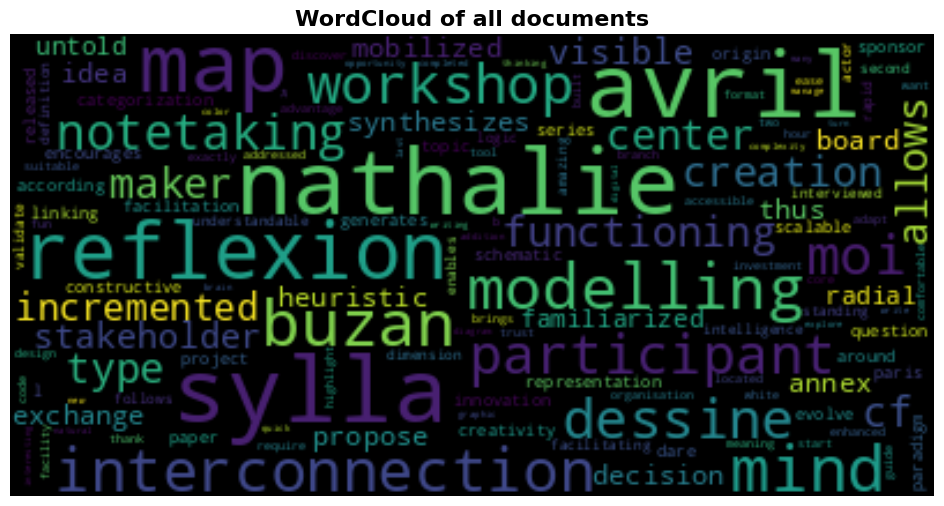

In [34]:
plot_wordcloud("WordCloud of all documents", tfidf_documents[0])

> - We observe that the most frequent terms include, for example, 'Nathalie,' which is a female name and may be prevalent in our data set due to a high occurrence of individuals with that name. Other potential names like Sylla, Avril, and Dessine also appear.
>
> - Furthermore, we note words such as 'idea,' 'decision,' 'stakeholder,' 'reflexion,' 'note-taking,' 'creating,' and 'board,' among many others in the same category. These remind us that we are working with data containing many documents that include summaries of one's job and career. Consequently, the presence of these terms is not surprising.

> - Next, we will visualize most frequent names in the data.

In [35]:
extracted_tokens_per_document = []

for _, row in df.iterrows():
    document_tokens = [token for token, label in zip(row['tokens'], row['labels']) if label in ['B-NAME_STUDENT', 'I-NAME_STUDENT']]
    extracted_tokens_per_document.append(document_tokens)

In [36]:
tokenize_names = [[word.lower() for word in sublist] for sublist in extracted_tokens_per_document]
tfidf_names = calc_td_idf(tokenize_names)
tfidf_names = {k: v for d in tfidf_names for k, v in d.items()}

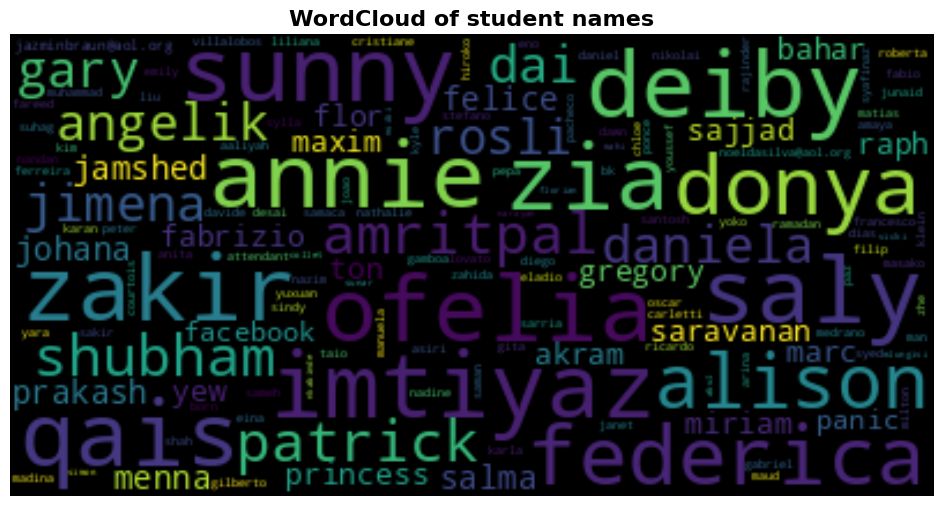

In [37]:
plot_wordcloud("WordCloud of student names", tfidf_names)

> - What we notice here is the variety of names. We see typically European/American names like "Federica," "Alison," "Daniela," "Saly," and other Estern names such as "Zakir," "Salma," "Qais," "Sajjad," and more. This is very good, as we will have diverse data set, which will be good for the model generalization. 
>
> - We also notice that "Facebook" is one of the names; however, we wonder whether this is misclassified. As previously mentioned, we expect there to be some errors in the labeling, as part of the annotations was semi-automated.
>
> - We also observe the name "princess," which could be used both as a proper noun and a common noun. In this context, the capitalization of the word is significant, as it could further indicate whether the word is employed as a name or a noun.
>
> - Thus, we will make same plots again without lowercasing the letters.

In [38]:
def preprocess_texts_without_lower(data_df):
    """
    This function preprocesses texts in a DataFrame by performing the following steps:
    1. Remove non-alphabetic characters and split the text into words.
    2. Remove stopwords using the English language stopwords set.
    3. Lemmatize the remaining words using WordNet lemmatizer.

    Args:
    - data_df: DataFrame with a 'text' column containing texts to be preprocessed.

    Returns:
    A single string containing the preprocessed and lemmatized words from the input texts.
    """

    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    processed_texts = []

    for document in data_df['text']: 
        # Remove non-alphabetic characters and split into words
        words = re.findall(r'\b[a-z]+\b', document)
        # Remove stopwords and lemmatize the words
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        # Join the lemmatized words into a single string and add it to the list
        processed_text = ' '.join(lemmatized_words)
        processed_texts.append(processed_text)

    return processed_texts

In [39]:
documents_not_lowercase = preprocess_texts_without_lower(df)

In [40]:
tokenize_documents_not_lowercase = [doc.split() for doc in documents_not_lowercase]
tfidf_documents_not_lowercase = calc_td_idf(tokenize_documents_not_lowercase)

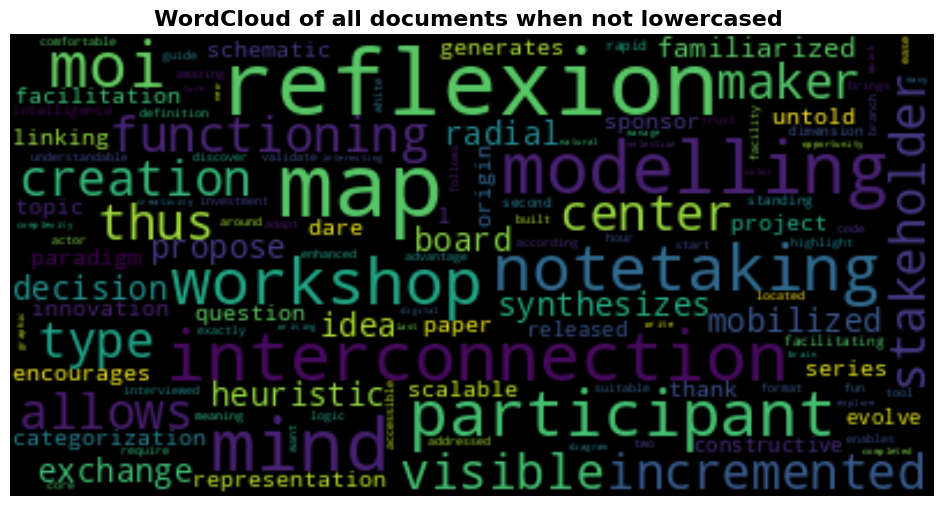

In [41]:
plot_wordcloud("WordCloud of all documents when not lowercased ", tfidf_documents_not_lowercase[0])

> - Firstly, we notice that the names that occured before, is not visible anymore. However, we see many of the same words as before as 'exchange,' 'decision,' 'stakeholder,' 'reflexion,' 'notetaking,' 'creation,' and 'center,' and many others. 

In [42]:
tokenize_names_not_lowercase = [[word for word in sublist] for sublist in extracted_tokens_per_document]
tfidf_names_not_lowercase = calc_td_idf(tokenize_names_not_lowercase)
tfidf_names_not_lowercase = {k: v for d in tfidf_names_not_lowercase for k, v in d.items()}

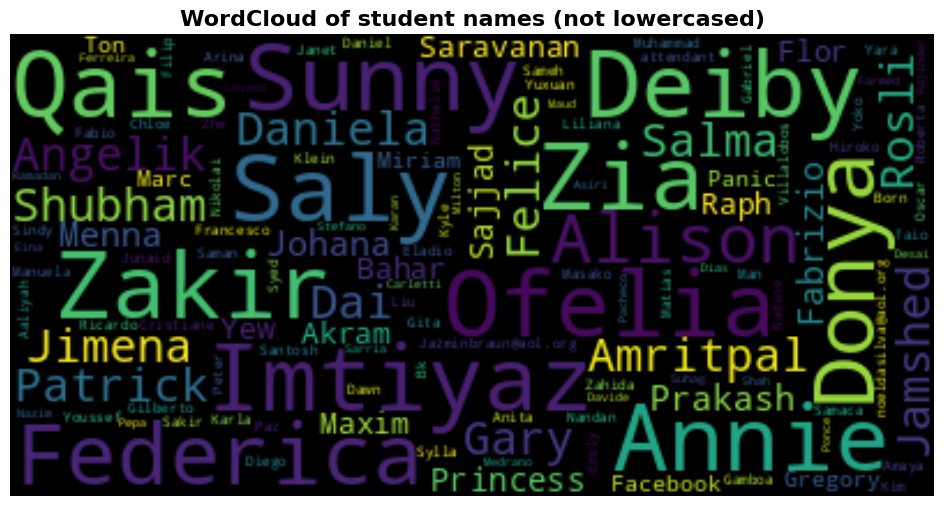

In [43]:
plot_wordcloud("WordCloud of student names (not lowercased)", tfidf_names_not_lowercase)

## lav et bar plot a mest common words

> - We observed many of the same names and we see that "Princess" is still in the wordcloud indicating that this word occur multiple times across the document as a name. However, this still open ups for considering to use the words without lowercasing as we will loss some information that may be important for the model. 

> - In the following, we will investigate whether there is specific words before the respective labels. We will only do the TF part of TF-IDF. This can serve as an understanding of where the labels occur in the data and whether there is some very specifikke words, which could be used to the baseline model for rules. 

In [142]:
def extract_tokens_before_labels(data_df, target_label, num_tokens=1):
    all_tokens_before_label = []
    
    for _, row in data_df.iterrows():
        tokens, labels = row['tokens'], row['labels']
        # lower case tokens 
        tokens = [token.lower() for token in tokens]
        tokens_before_label = [
            tokens[i-num_tokens:i] 
            for i, label in enumerate(labels) 
            if label == target_label and i-num_tokens >= 0
        ]
        all_tokens_before_label.extend(tokens_before_label)
    
    return all_tokens_before_label

def clean_tokens(tokens):
    cleaned_tokens_per_document = [
    [re.sub(r'[^\w\s]', '', token) for token in sublist]
    for sublist in tokens]

    cleaned_tokens_per_document = [
        [token for token in sublist if token.strip()]
        for sublist in cleaned_tokens_per_document]

    all_tokens = [token for sublist in cleaned_tokens_per_document for token in sublist]
    return all_tokens

def plot_most_common_words(tokens, title, num_most_common_words=10):
    all_tokens = clean_tokens(tokens)
    # Count the frequencies of each word
    word_counts = Counter(all_tokens)
    # Get the most common words and their counts
    most_common_words = word_counts.most_common(num_most_common_words)
    words, frequencies = zip(*most_common_words)
    # Create a bar plot
    fig = go.Figure([go.Bar(x=words, y=frequencies, marker_color=color_theme['three_colors'][2])])
    fig.update_layout(title=title, xaxis_title='Words', yaxis_title='Frequency')
    fig.show()

In [143]:
# Extracting the two tokens before:
tokens_before_B_NAME_STUDENT = extract_tokens_before_labels(df, 'B-NAME_STUDENT')
tokens_before_B_STREET_ADDRESST = extract_tokens_before_labels(df, 'B-STREET_ADDRESS')
tokens_before_B_PHONE_NUM = extract_tokens_before_labels(df, 'B-PHONE_NUM')
tokens_before_B_URL_PERSONAL = extract_tokens_before_labels(df, 'B-URL_PERSONAL')
tokens_before_B_EMAIL= extract_tokens_before_labels(df, 'B-EMAIL')

In [ ]:
plot_most_common_words(tokens_before_B_NAME_STUDENT, "Most common words before B-NAME_STUDENT", 20)

> - This figure displays the most common words preceding the target `B-NAME-STUDENT`. Most of these words are unremarkable pronouns such as "is", "of", and "am". 
> - However, some notable exceptions are "Dr", "officer" and "professor", which suggests that some individuals use a title before their names. This could serve as an indication of a name, adding an interesting dimension to the analysis.

In [ ]:
plot_most_common_words(tokens_before_B_STREET_ADDRESST, "Most common words before B-STREET_ADDRESS", 20)

> - Here, we observe the most common words preceding the target `B-STREET-ADDRESS`. It is unsurprising that "at" frequently appears in this context. However, we anticipated a higher occurrence of words like "address" and "street." 
> - Nevertheless, this insight can be leveraged to enhance our baseline model by combining other indicative factors of an address with the word "at." For example, if certain criteria are met alongside the appearance of "at," we could classify the phrase as an address.

In [ ]:
plot_most_common_words(tokens_before_B_PHONE_NUM, "Most common words before B-PHONE_NUM", 20)

> - For the target `B-PHONE-NUM`, we once again find that words such as "at", "is", and "or" are most common. Interestingly, "number" also appears frequently following these conjunctions and prepositions. This pattern underscores potential cues for identifying phone numbers in text data.
> - Additionally, we observe words such as "call", "calling", "digits", and "phone", which are contextually related to phone numbers. However, their occurrence is not frequent enough to reliably use them as part of the regex model for identifying phone numbers.

In [ ]:
plot_most_common_words(tokens_before_B_URL_PERSONAL, "Most common words before B-URL_PERSONAL", 20)

> - For the target `B-URL_PERSONAL`, we see the same tendency. Interestingly, "webpage" and "website" also appears, but not so commonly.  

In [ ]:
plot_most_common_words(tokens_before_B_EMAIL, "Most common words before B-EMAIL", 20)

- For the target `B_EMAIL`, we see no interesting words.

> - Overall, this analysis reveals that the most common words preceding the targets are pronouns, which is not so surprising. However, we had expected to see terms like "email," "street address," and "website" occurring more frequently before their respective targets. Such occurrences could have been highly beneficial for developing our baseline model.

___________

<a id="5"></a>
# Section 5: Named Entity Recognition using Regex

In [127]:
# define regex patterns based on the rules
patterns = {
    'NAME_STUDENT': re.compile(r'\b([A-Z][a-z]+)(\s+[A-Z][a-z]+)+\b'),
    'EMAIL': re.compile(r'\b[\w.-]+@[\w.-]+\b'),
    'ID_NUM': re.compile(r'(?<!\d)(?<!\d\s)\b\d{10,14}\b(?!\s\d)(?!\d)'), 
    'PHONE_NUM': re.compile(r'(?:\(\d{3}\)\d{3}-\d{4})|(?:\d{3}\.\d{3}\.\d{4})'),
    'STREET_ADDRESS': re.compile(r'\b(\d{2,4})\s+([A-Z][a-z]+(?:\s+[A-Z][a-z]+)*)\b'),
    'URL_PERSONAL': re.compile(r'\b(?:http://www\.|https://www\.|http://|https://)[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,5}\b'),
    'USERNAME': re.compile(r'\s(@[a-zA-Z\d]+)')
}

In [160]:
def match_regex_patterns(tokens: list, patterns: dict):
    # Join all tokens into a single string with spaces
    text = ' '.join(tokens)
    
    # Initialize the matches list with 'O'
    matches = ['O'] * len(tokens)
    
    # Mapping from index in tokens to index in text
    current_position = 0
    token_indices = []
    for token in tokens:
        token_indices.append(current_position)
        current_position += len(token) + 1  # account for the token and a space
    
    # Apply each regex to the full text
    for key, pattern in patterns.items():
        for match in pattern.finditer(text):
            start_index = match.start()
            end_index = match.end()
            
            # Find which tokens are covered by this match
            start_token = next(i for i, pos in enumerate(token_indices) if pos <= start_index and (i+1 == len(token_indices) or token_indices[i+1] > start_index))
            end_token = next(i for i, pos in enumerate(token_indices) if pos < end_index and (i+1 == len(token_indices) or token_indices[i+1] >= end_index))
            
            # Assign the match key to the corresponding tokens
            for i in range(start_token, end_token + 1):
                matches[i] = key

    return matches

def convert_to_bio_format(labels: list):
    bio_labels = ['O'] * len(labels)
    for i, label in enumerate(labels):
        if label != 'O':
            if i == 0: 
                bio_labels[i] = 'B-' + label
            if (i > 0) & (labels[i] == labels[i-1]): # Check if the previous token has the same label
                bio_labels[i] = 'I-' + label
            else:
                bio_labels[i] = 'B-' + label
    return bio_labels

In [129]:
df['matched_regex_labels'] = df['tokens'].apply(lambda tokens: match_regex_patterns(tokens, patterns))


In [154]:
mask = df['matched_regex_labels'].apply(lambda labels: 'USERNAME' in labels)

# Filter the DataFrame using the mask
df_with_id_num = df[mask]

In [161]:
# df_with_id_num['matched_regex_labels'].iloc[0]

In [162]:
# df_with_id_num['matched_regex_bio_labels'].iloc[1]

In [163]:
test = ['on',
 'Twitter',
 '(',
 '@ashok.ma',
 ')',
 'or',
 'visit',
 'my',
 'webpage',
 '(',
 'https://www.ashok-ma.com/news',
 ')',
 'for',
 'more',
 'information',
 'about',
 'my',
 'work',
 '.']

match_regex_patterns(test, patterns)

URL_PERSONAL
USERNAME
USERNAME


['O',
 'O',
 'USERNAME',
 'USERNAME',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'URL_PERSONAL',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [158]:
df_with_id_num['tokens'].iloc[1]

['Hi',
 ',',
 'I',
 "'m",
 'Ashok',
 'Ma',
 ',',
 'a',
 'software',
 'developer',
 'at',
 'a',
 'tech',
 'company',
 '.',
 'Recently',
 ',',
 'I',
 'encountered',
 'a',
 'challenging',
 'issue',
 'that',
 'required',
 'my',
 'expertise',
 '.',
 'Our',
 'software',
 'application',
 'was',
 'experiencing',
 'intermittent',
 'crashes',
 ',',
 'leading',
 'to',
 'user',
 'dissatisfaction',
 'and',
 'potential',
 'business',
 'impact',
 '.',
 'The',
 'problem',
 'seemed',
 'random',
 ',',
 'making',
 'it',
 'difficult',
 'to',
 'pinpoint',
 'the',
 'root',
 'cause',
 '.',
 'I',
 'delved',
 'into',
 'the',
 'codebase',
 ',',
 'analyzing',
 'logs',
 ',',
 'and',
 'conducting',
 'rigorous',
 'testing',
 'to',
 'isolate',
 'the',
 'issue',
 '.',
 'I',
 'identified',
 'a',
 'memory',
 'leak',
 'in',
 'a',
 'specific',
 'module',
 'that',
 'caused',
 'the',
 'application',
 'to',
 'crash',
 'under',
 'certain',
 'conditions',
 '.',
 'I',
 'promptly',
 'devised',
 'a',
 'solution',
 'by',
 'implem

In [130]:
df['matched_regex_bio_labels'] = df['matched_regex_labels'].apply(lambda labels: convert_to_bio_format(labels))

In [137]:
#np.unique(regex_predicted_labels_list)

In [131]:
true_labels_list = df['labels'].explode().tolist()
regex_predicted_labels_list = df['matched_regex_bio_labels'].explode().tolist()

# Ensure both lists have the same length before continuing
assert len(true_labels_list) == len(regex_predicted_labels_list), "The lists of true and predicted labels must be the same length."

# Get unique labels/classes 
unique_labels = np.unique(true_labels_list + regex_predicted_labels_list)

In [133]:
# Filter out 'O' from true_labels_list and keep track of indices
filtered_labels = [(label, idx) for idx, label in enumerate(true_labels_list) if label != 'O']

# Extract labels and indices separately
kept_labels = [label for label, _ in filtered_labels]
kept_indices = [idx for _, idx in filtered_labels]

# Apply the same indices to predicted list 
filtered_true_labels =  [true_labels_list[idx] for idx in kept_indices]
filtered_pred_list = [regex_predicted_labels_list[idx] for idx in kept_indices]


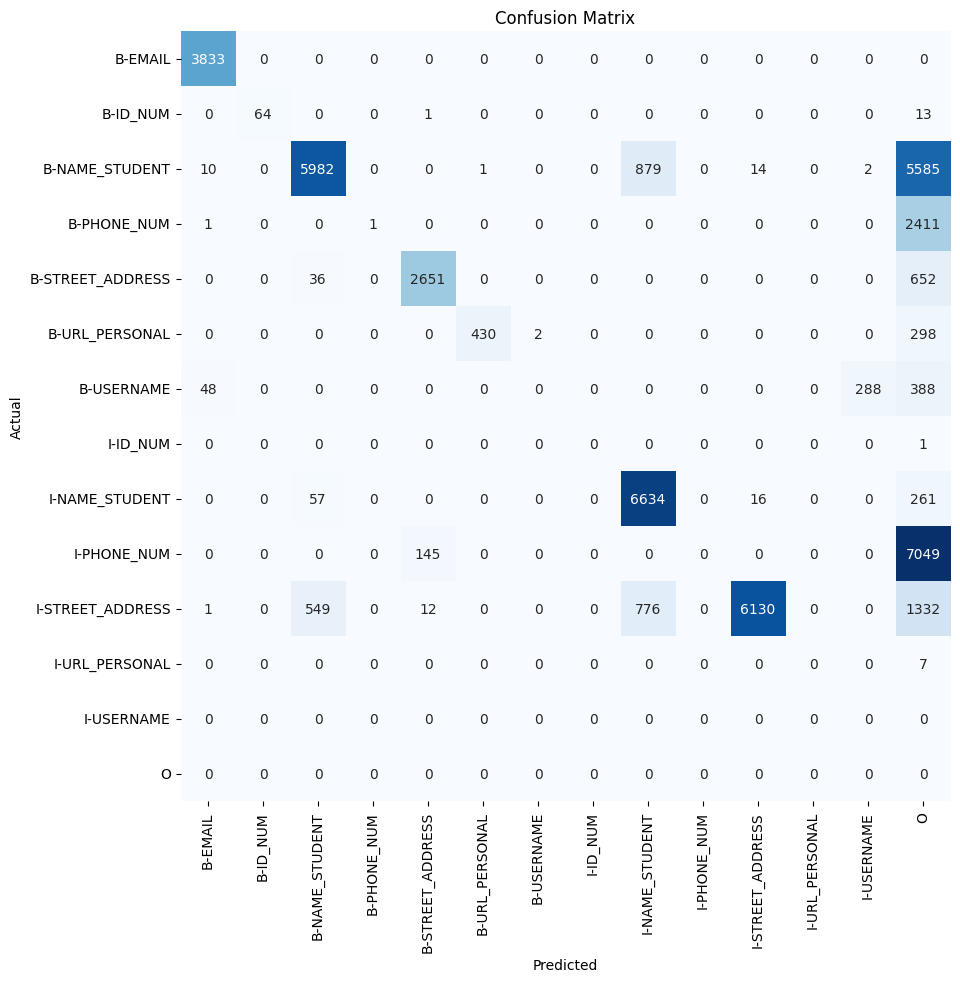

In [134]:
# Generate the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(filtered_true_labels, filtered_pred_list, labels=unique_labels)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=unique_labels, yticklabels=unique_labels, square=True, cmap='Blues', cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [80]:
accuracy_without_O = accuracy_score(filtered_true_labels, filtered_pred_list)
print("Accuracy after removing Label O:", accuracy_without_O)

Accuracy after removing Label O: 0.09753006872852234


In [139]:
precision = precision_score(filtered_true_labels, filtered_pred_list, average=None, labels=unique_labels)
recall = recall_score(filtered_true_labels, filtered_pred_list, average=None, labels=unique_labels)
f1 = f1_score(filtered_true_labels, filtered_pred_list, average=None, labels=unique_labels)

/Users/jasmink.j.thari/Documents/anaconda3/envs/Detect_PII/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/Users/jasmink.j.thari/Documents/anaconda3/envs/Detect_PII/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [82]:
f1_micro = f1_score(filtered_true_labels, filtered_pred_list, average='micro')

print(f"F1 Score (Micro-average): {f1_micro:.2f}")

F1 Score (Macro-average): 0.21
F1 Score (Micro-average): 0.10
F1 Score (Weighted-average): 0.10


In [88]:
precision = precision_score(filtered_true_labels, filtered_pred_list, average= 'micro')
recall = recall_score(filtered_true_labels, filtered_pred_list, average= 'micro')

print("Precision:", precision)
print("Recall:", recall)

/Users/jasmink.j.thari/Documents/anaconda3/envs/Detect_PII/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.29876064775786165
Recall: 0.20782685847711654


/Users/jasmink.j.thari/Documents/anaconda3/envs/Detect_PII/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [140]:
def color_for_value(value):
    if value < 0.50:
        return "red"
    elif value < 0.70:
        return "yellow"
    else:
        return "green"

# Start of the HTML table
html = "<table style='width:60%; border: 1px solid black; border-collapse: collapse;'>"
html += "<tr>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Class</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Precision</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Recall</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>F1 Score</th>"
html += "</tr>"

# Adding data rows with color-coded values
for label, p, r, f in zip(unique_labels, precision, recall, f1):
    html += f"<tr>"
    html += f"<td style='border: 1px solid black; padding: 8px;'>{label}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(p)};'>{p:.2f}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(r)};'>{r:.2f}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(f)};'>{f:.2f}</td>"
    html += "</tr>"

# Closing the table
html += "</table>"

# Displaying the table in Jupyter Notebook
display(HTML(html))

Class,Precision,Recall,F1 Score
B-EMAIL,0.98,1.00,0.99
B-ID_NUM,1.00,0.82,0.90
B-NAME_STUDENT,0.90,0.48,0.63
B-PHONE_NUM,1.00,0.00,0.00
B-STREET_ADDRESS,0.94,0.79,0.86
B-URL_PERSONAL,1.00,0.59,0.74
B-USERNAME,0.00,0.00,0.00
I-ID_NUM,0.00,0.00,0.00
I-NAME_STUDENT,0.80,0.95,0.87
I-PHONE_NUM,0.00,0.00,0.00


____

<a id="6"></a>
# Section 6: Named Entity Recognition using Transformer Model

In [32]:
import sys
import json
import os
import pandas as pd
# from omegaconf import OmegaConf
#import timm

from datasets import load_dataset, load_from_disk
from transformers import (AutoTokenizer, 
                          AutoModelForTokenClassification, 
                          DataCollatorForTokenClassification, 
                          TrainingArguments, 
                          Trainer,
                          pipeline,)
# import evaluate
import torch
import numpy as np
import datetime

In [ ]:
model_folder = "model_train_uncased/config_1/2024-04-17_10-19-10/best_model"

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
classifier = pipeline("ner", model=model_folder, tokenizer=tokenizer)

In [29]:
from transformers import AutoModel, AutoTokenizer
import timm

# # Example of a correct local path
# local_model_path = "https://huggingface.co/wejendorp/ABA_NER/tree/main/config_1/2024-04-17_10-19-10/best_model"  # Adjust this to the correct local path

# # Load the tokenizer and model from a local directory
# tokenizer = AutoTokenizer.from_pretrained(local_model_path)
# model = AutoModel.from_pretrained(local_model_path)


timm.create_model('hf_hub:wejendorp/ABA_NER', pretrained=True)


EntryNotFoundError: 404 Client Error. (Request ID: Root=1-661fb510-693d2361459d37116c8cc154;bccfb1d3-3f8d-413e-beb6-90ae2e64fd3c)

Entry Not Found for url: https://huggingface.co/wejendorp/ABA_NER/resolve/main/config.json.

In [16]:
from transformers import AutoModel, AutoTokenizer, pipeline

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

# Load the model
#model = AutoModel.from_pretrained("bert-base-uncased")
AutoModel.from_pretrained("wejendorp/ABA_NER")

OSError: Incorrect path_or_model_id: 'wejendorp/ABA_NER/config_1/2024-04-17_10-19-10/best_model'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [10]:
classifier = pipeline("ner", model="/w", tokenizer=tokenizer)

OSError: Incorrect path_or_model_id: '/wejendorp/ABA_NER'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Vi laver et nyt plot hvor vi ser hvor stor en andel af de sidste ord i sætningerne som indholder labels. 

____

<a id="7"></a>
# Section 7: Discussion